## BloomTech Data Science

---


# Cross-Validation

- Do **k-fold cross-validation** with independent test set
- Use scikit-learn for **hyperparameter optimization**

In [1]:
%%capture
!pip install category_encoders==2.*

In [18]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API. 

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [3]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contians the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so. 
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [6]:
# List all files in your Kaggle folder on your google drive.
!ls

new_submission.csv     test_features.csv   train_labels.csv
sample_submission.csv  train_features.csv


# I. Wrangle Data

In [28]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, 
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns
  dupe_cols = [col for col in df.head(100).T.duplicated().index # change 15 to 100!!!!
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)             

  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

In [29]:
df.shape, X_test.shape

((47519, 31), (11880, 30))

# II. Split Data

## Split TV from FM

In [32]:
target = 'status_group'
y = df[target]
X = df.drop(columns = target)

# Training-Validation Split

In [33]:
# Skip train-val split because the cross-val function does this under the hood (several times)

# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [34]:
y.value_counts(normalize = True).max()

0.5429828068772491

# IV. Build Models

- `DecisionTreeClassifier`
- `RandomForestClassifier`

In [35]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42));

In [37]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=25, random_state=42)
);

# fitting the models is also taken care of by cross-validation function!

In [50]:
# kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42) (this is basically to showcase the "shuffle" option, use it when you have sorted data that you wanna jumble up)

dt_cv_scores = cross_val_score(model_dt, X, y, cv=5, n_jobs=-1) 
#cv is the 'k' variable from the k-fold cross validation formula, it just asks how many times you want to split and run the scoring. normally set it to 10
# n-jobs basically allows for multi-threading(? might be using the term wrong) But in collabs we don't wanna fuck with that 
  # But like it lets the function run through multiple cores simultaneously making it a lot faster and allowing for efficient operation on much higher data volumes/higher cv values

In [51]:
rf_cv_scores = cross_val_score(model_rf, X, y, cv=5, n_jobs=-1)

In [52]:
dt_cv_scores

array([0.7444234 , 0.75126263, 0.74621212, 0.74863215, 0.7457645 ])

In [53]:
rf_cv_scores

array([0.79335017, 0.79692761, 0.79724327, 0.79892677, 0.79438072])

**Check cross-validation scores**

![Cross Validation](https://upload..org/wikipedia/commons/4/4b/KfoldCV.gif)

In [54]:
print('CV score DecisionTreeClassifier')
print('Mean CV accuracy score: ', dt_cv_scores.mean())
print('STD CV accuracy score: ', dt_cv_scores.std())

CV score DecisionTreeClassifier
Mean CV accuracy score:  0.7472589596905601
STD CV accuracy score:  0.0024201115777066104


In [55]:
print('CV score RandomForestClassifier')
print('Mean CV accuracy score:', rf_cv_scores.mean())
print('STD CV accuracy score:', rf_cv_scores.std())

CV score RandomForestClassifier
Mean CV accuracy score: 0.7961657066650226
STD CV accuracy score: 0.0020237843032747736


# V. Tune Model

Different hyperparameter values I want to try out :

*   Simpleimputer - mean, median - 2 values
*   max_depth - range(5,40,5) - 7 values
*   n_estimators - range(25,125,25) - 4 values

> Total combinations of these hyperparameters = 2 * 7 * 4 = 56

Testing out the above hyperparameter combinations with 5-fold Cross Validation will need :

> Total number of models to be fit = 2 * 7 * 4 * 5 = 280


In [57]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

In [58]:
param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5,40,5),
    'randomforestclassifier__n_estimators': range(25,125,25)
}

**`GridSearch`:** 

**Warning! This next cell is gunna take forever to run!**


In [59]:
model_rf_gs = GridSearchCV(clf,
             param_grid=param_grid,
             n_jobs=-1,
             cv=5,
             verbose=1)

model_rf_gs.fit(X,y)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 40, 5),
                         'randomforestclassifier__n_estimators': range(25, 125, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [60]:
model_rf_gs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'mean'}

In [61]:
model_rf_gs.best_score_

0.8033627937270207

In [62]:
model_rf_gs.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 

In [63]:
model_rf_gs.predict(X_test)

array(['non functional', 'functional', 'functional', ...,
       'non functional', 'functional', 'functional'], dtype=object)

**`RandomizedSearchCV`:** 

In [64]:
model_rf_rs = RandomizedSearchCV(clf, param_grid,
                   n_jobs=-1,
                   verbose=1,
                   n_iter=7,
                   cv=5);
model_rf_rs.fit(X,y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=7, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 40, 5),
                                        'randomforestclassifier__n_estimators': range(25, 125, 25),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

In [65]:
model_rf_rs.best_params_

{'simpleimputer__strategy': 'mean',
 'randomforestclassifier__n_estimators': 75,
 'randomforestclassifier__max_depth': 20}

In [66]:
model_rf_rs.best_score_

0.8022684954883997

In [ ]:
# the point here is that the random will normally get you pretty close to the optimal, but much faster
# However grid will obviously be a little more optimal

# VI. Communicate Results

**Showing Feature Importance**

Plot the feature importance for our `RandomForest` model.

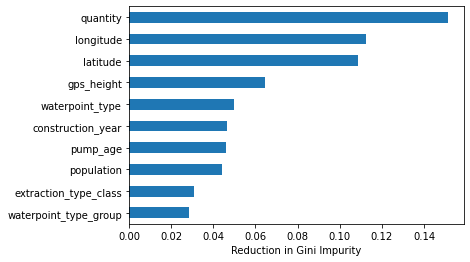

In [67]:
bestestimator = model_rf_gs.best_estimator_
importances = bestestimator.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

# VII. Make Submission

In [68]:
y_pred = model_rf_gs.predict(X_test)

In [69]:
submission = pd.DataFrame({'status_group':y_pred}, index=X_test.index)

In [70]:
submission

,status_group
id,
37098,non functional
14530,functional
62607,functional
46053,non functional
47083,functional
...,...
26092,functional
919,non functional
47444,non functional


In [71]:
pd.Timestamp.now().strftime('%Y-%m-%d_%H%M_')

'2022-11-09_1838_'

In [72]:
datestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H%M_') #string from time format
submission.to_csv(f'{datestamp}submission.csv') #format string

# VIII. Saving a trained model to reuse it in the future

In [73]:
# Once you have found the best model, you might as well save it and then reload it when you want to test it later

# save model
import pickle

filename = 'model_rf_gs_8033'

#save your model (it will be stored in your current working directory - download to your computer if GDrive is not mounted)
pickle.dump(bestestimator,open(filename,'wb'))
#load model
# model_rf_loaded = pickle.load(open(filename,'rb'))